<a href="https://colab.research.google.com/github/cchang-vassar/Semantic-Relations-in-Vector-Embeddings/blob/main/study1_6_%5Bada003%5Dcounterevidence_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [ada-003] Current Embeddings of Arguments and Counterarguments

## Set Up

### Imports

In [ ]:
# General imports
import os
import zipfile
import shutil
import subprocess
import re
import pickle
import numpy as np
import pandas as pd
from enum import Enum
from typing import Optional
from ctypes import Union
from google.colab import userdata

### OSF Setup

In [ ]:
!pip install osfclient

In [ ]:
os.environ["OSF_USERNAME"] = userdata.get("OSF_USERNAME")
OSF_USERNAME = os.environ["OSF_USERNAME"]

In [ ]:
os.environ["OSF_PASSWORD"] = userdata.get("OSF_PASSWORD")
OSF_PASSWORD = os.environ["OSF_PASSWORD"]

In [ ]:
os.environ["OSF_TOKEN"] = userdata.get("OSF_TOKEN")
OSF_TOKEN = os.environ["OSF_TOKEN"]

In [ ]:
os.environ["OSF_PROJECT_ID"] = userdata.get("OSF_PROJECT_ID")
OSF_PROJECT_ID = os.environ["OSF_PROJECT_ID"]

### OpenAI Setup

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
import openai
from openai import OpenAI
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
client = OpenAI()

### Class Declarations

In [ ]:
# Enum for processing unit
class ProcessingUnit(Enum):
  GLOBAL = "global"
  CATEGORY = "category"
  DEBATE = "debate"

## Get Embeddings

### [Imports] Get Embeddings

In [ ]:
!pip install tenacity

In [ ]:
import time
from tenacity import (
  retry,
  stop_after_attempt,
  wait_random_exponential
)

### [OSF-Import] Import embeddings dump from OSF

In [ ]:
def import_embeddings_dump():
  """Import embeddings_dump from OSF"""
  subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada003-autoencoder/ada_evidence_embeddings_dump.zip", shell=True)
  print("ada_evidence_embeddings_dump.zip successfully imported")

  embeddings_dump_file_path_zip = 'ada_evidence_embeddings_dump.zip'
  embeddings_dump_file_path = 'current-data-dump/embeddings-dump'
  os.makedirs(embeddings_dump_file_path, exist_ok=True)
  with zipfile.ZipFile(embeddings_dump_file_path_zip, 'r') as zip_ref:
    zip_ref.extractall(embeddings_dump_file_path)

  extracted_files = os.listdir(embeddings_dump_file_path)
  print("Files extracted:", extracted_files)

### [Write] Embeddings df

In [ ]:
def _embeddings_write_to_file(
  embeddings_df: pd.DataFrame,
  file_name: str
  ):
  """Write extracted embeddings to pickle file"""
  folder_path = f'current-data-dump/embeddings-dump/'
  file_path = f'{folder_path}{file_name}.pkl'

  os.makedirs(folder_path, exist_ok=True)
  with open(file_path, 'wb') as file:
    pickle.dump(embeddings_df, file)
    print(f"File uploaded to {file_path}")

### [All] Embeddings df

In [ ]:
DIM_EMBEDDING = 1536

@retry(wait=wait_random_exponential(min=60, max=500), stop=stop_after_attempt(10))
def _get_embeddings(arguments: list) -> list:
  """Convert an argument into a (1 x 1536) embedding df"""
  embeddings = client.embeddings.create(input=arguments, model="text-embedding-3-small")
  embeddings_data = [embedding_data.embedding for embedding_data in embeddings.data]
  embeddings_df = pd.DataFrame(embeddings_data, columns=[f"{str(i)}" for i in range(DIM_EMBEDDING)])
  return embeddings_df.reset_index(drop=True)

In [ ]:
API_LIMIT = 1000

def get_embeddings_df(arguments_df: pd.DataFrame) -> pd.DataFrame:
  """Add embeddings column to a df"""
  arguments_embeddings_df = pd.DataFrame()
  evidence_embeddings_df = pd.DataFrame()
  arguments_list = list(arguments_df['topic'])
  evidence_list = list(arguments_df['candidate'])
  total_len = len(arguments_list)
  i = 0

  # Grab embeddings from arguments + evidence columns in chunks
  while i < total_len:
    arguments_embeddings = _get_embeddings(arguments_list[i:min(total_len, i+API_LIMIT)])
    evidence_embeddings = _get_embeddings(evidence_list[i:min(total_len, i+API_LIMIT)])
    arguments_embeddings_df = pd.concat([arguments_embeddings_df, arguments_embeddings], axis=0, ignore_index=True)
    evidence_embeddings_df = pd.concat([evidence_embeddings_df, evidence_embeddings], axis=0, ignore_index=True)
    i = i + API_LIMIT
  arguments_embeddings_df['argument'] = arguments_list
  evidence_embeddings_df['evidence'] = evidence_list

  # Write embeddings df to file
  _embeddings_write_to_file(arguments_embeddings_df, 'argument_embeddings')
  _embeddings_write_to_file(evidence_embeddings_df, 'evidence_embeddings')
  return (arguments_embeddings_df, evidence_embeddings_df)

### [OSF-Export] Export embeddings dump to OSF

In [ ]:
def export_embeddings_dump():
  """Export embeddings_dump to OSF"""
  embeddings_dump_file_path = 'current-data-dump/embeddings-dump'
  embeddings_dump_file_path_zip = 'current-data-dump/embeddings-dump'
  shutil.make_archive(embeddings_dump_file_path_zip, 'zip', embeddings_dump_file_path)
  print(f"Zip file created at: {embeddings_dump_file_path_zip}")
  result = subprocess.run([f"osf -p sakjg upload --force {embeddings_dump_file_path_zip}.zip data-dump/ada003-autoencoder/ada_evidence_embeddings_dump.zip"], shell=True, capture_output=True, text=True)
  print(result.stderr)
  print(f"File: {embeddings_dump_file_path_zip} uploaded at osfstorage")

## Analyze Embeddings

### [Imports] Analysis df

In [ ]:
import joblib
from sklearn.decomposition import PCA

### [OSF-Import] Import pca dump from OSF

In [ ]:
def import_pca_dump():
  """Import pca_dump from OSF"""
  subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada003-autoencoder/ada_evidence_pca_dump.zip", shell=True)
  print("pca_dump.zip successfully imported")

  pca_dump_file_path_zip = 'ada_evidence_pca_dump.zip'
  pca_dump_file_path = 'current-data-dump/pca-dump'
  with zipfile.ZipFile(pca_dump_file_path_zip, 'r') as zip_ref:
    zip_ref.extractall(pca_dump_file_path)

  extracted_files = os.listdir(pca_dump_file_path)
  print("Files extracted:", extracted_files)

### [Write] Analysis df

In [ ]:
def _analysis_write_to_file(
  analysis_df: pd.DataFrame,
  pca: PCA,
  file_name: str,
  ):
  """Write analysis results to pickle file"""
  folder_path = f'current-data-dump/pca-dump/'
  file_path = f'{folder_path}{file_name}.pkl'
  pca_file_path = f'{folder_path}{file_name}_obj.pkl'
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  with open(file_path, 'wb') as file:
    pickle.dump(analysis_df, file)
    print(f"File uploaded to {file_path}")
  joblib.dump(pca, pca_file_path)
  print(f"PCA object file uploaded to {pca_file_path}")

### [Debate] Analysis df

In [ ]:
def pca_normalization(argument_embeddings_df: pd.DataFrame, evidence_embeddings_df: pd.DataFrame) -> pd.DataFrame: # side effect function
  """Normalize PCA argument embeddings from a df"""
  arguments = argument_embeddings_df["argument"].copy()
  evidences = evidence_embeddings_df["evidence"].copy()
  argument_embeddings_df.drop(['argument'], axis=1, inplace=True)
  evidence_embeddings_df.drop(['evidence'], axis=1, inplace=True)

  mean_vecs = (argument_embeddings_df + evidence_embeddings_df) / 2

  argument_embeddings_df = argument_embeddings_df.subtract(mean_vecs)
  evidence_embeddings_df = evidence_embeddings_df.subtract(mean_vecs)

  argument_embeddings_df["text"] = arguments
  argument_embeddings_df["argument_evidence"] = "argument"
  evidence_embeddings_df["text"] = evidences
  evidence_embeddings_df["argument_evidence"] = "evidence"
  return (argument_embeddings_df, evidence_embeddings_df)

In [ ]:
def pca_embeddings(
    num_components: int,
    argument_embeddings_df: pd.DataFrame,
    evidence_embeddings_df: pd.DataFrame,
    file_name: str
  ):
  normalized_embeddings_df = pca_normalization(argument_embeddings_df.copy(), evidence_embeddings_df.copy())
  argument_embeddings_normalized = normalized_embeddings_df[0]
  evidence_embeddings_normalized = normalized_embeddings_df[1]
  interleaved_df = pd.concat([argument_embeddings_normalized, evidence_embeddings_normalized], keys=[0, 1])
  interleaved_df = interleaved_df.sort_index(level=[1, 0])
  interleaved_df.reset_index(drop=True, inplace=True)
  interleaved_text = interleaved_df["text"]
  interleaved_type = interleaved_df["argument_evidence"]
  interleaved_df.drop(["text", "argument_evidence"], axis=1, inplace=True)

  num_components = min(num_components, interleaved_df.shape[0], interleaved_df.shape[1])
  pca = PCA(n_components=num_components)
  embeddings_pca = pca.fit_transform(interleaved_df)
  embeddings_pca_data = pd.DataFrame(embeddings_pca, columns=['pca_{}'.format(i) for i in range(num_components)])
  embeddings_pca_data["text"] = interleaved_text
  last_elem = interleaved_text.iloc[-1]
  interleaved_text = interleaved_text.shift(1)
  interleaved_text.iloc[0] = last_elem
  embeddings_pca_data["argument"] = interleaved_text
  embeddings_pca_data["argument_evidence"] = interleaved_type
  embeddings_pca_data["pair_id"] = embeddings_pca_data.index // 2

  # Printing PCA attributes
  components = pca.components_
  explained_variance = pca.explained_variance_
  explained_variance_ratio = pca.explained_variance_ratio_
  singular_values = pca.singular_values_
  mean_value = pca.mean_
  n_components = pca.n_components_
  n_features = pca.n_features_in_
  n_samples = pca.n_samples_

  # Displaying the attributes
  print("Components:")
  print(components)
  print("\nExplained Variance:")
  print(explained_variance)
  print("\nExplained Variance Ratio:")
  print(explained_variance_ratio)
  print("\nSingular Values:")
  print(singular_values)
  print("\nMean:")
  print(mean_value)
  print("\nNumber of Components:")
  print(n_components)
  print("\nNumber of Features:")
  print(n_features)
  print("\nNumber of Samples:")
  print(n_samples)

  # Write to file
  _analysis_write_to_file(embeddings_pca_data, pca, file_name)
  return embeddings_pca_data

### [Global] Analysis df

In [ ]:
def global_analyze_embeddings(
  num_components: int,
  argument_embeddings_df: pd.DataFrame,
  evidence_embeddings_df: pd.DataFrame,
  file_name: str
  ):
  """Analyze argument embeddings from a global df"""
  global_embeddings_analysis = pca_embeddings(num_components, argument_embeddings_df, evidence_embeddings_df, file_name)

  # Write to file for facet
  output_folder = f'current-data-dump/pca-dump/'
  output_file_path = f'{output_folder}{file_name}.pkl'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
  global_embeddings_analysis.to_pickle(output_file_path)
  return global_embeddings_analysis

### [OSF-Export] Export pca dump to OSF

In [ ]:
def export_pca_dump():
  """Export pca_dump to OSF"""
  pca_dump_file_path = 'current-data-dump/pca-dump'
  pca_dump_file_path_zip = 'current-data-dump/pca-dump'
  shutil.make_archive(pca_dump_file_path_zip, 'zip', pca_dump_file_path)
  print(f"Zip file created at: {pca_dump_file_path_zip}")
  result = subprocess.run([f"osf -p sakjg upload --force {pca_dump_file_path_zip}.zip data-dump/ada003-autoencoder/ada_evidence_pca_dump.zip"], shell=True, capture_output=True, text=True)
  print(result.stderr)
  print(f"File: {pca_dump_file_path_zip} uploaded at osfstorage")

## Plot Embeddings

### [Imports] Analysis Plot

In [ ]:
from plotnine import ggplot, geom_point, geom_text, geom_bar, geom_line, geom_histogram, scale_x_continuous, aes, theme, theme_void, labs, element_text, facet_wrap, ggsave, scale_x_continuous, scale_y_continuous

### [OSF-Import] Import plots dump from OSF

In [ ]:
def import_pca_plots_dump():
  """Import pca_plots_dump from OSF"""
  subprocess.run("osf -p sakjg fetch --force osfstorage/data-dump/ada003-autoencoder/ada_evidence_pca_plots_dump.zip", shell=True)
  print("pca_evidence_plots_dump.zip successfully imported")

  pca_plots_dump_file_path_zip = 'ada_evidence_pca_plots_dump.zip'
  pca_plots_dump_file_path = 'current-data-dump/pca-plots-dump'
  with zipfile.ZipFile(pca_plots_dump_file_path_zip, 'r') as zip_ref:
    zip_ref.extractall(pca_plots_dump_file_path)

  extracted_files = os.listdir(pca_plots_dump_file_path)
  print("Files extracted:", extracted_files)

### [Global] Analysis Plot

In [ ]:
def _insert_line_breaks(text, max_width=50):
  """Insert line breaks in text"""
  words = text.split(' ')
  lines = []
  current_line = ''

  for word in words:
    if len(current_line) + len(word) <= max_width:
      current_line += word + ' '
    else:
      lines.append(current_line.strip())
      current_line = word + ' '

  lines.append(current_line.strip())
  return '\n'.join(lines)

In [ ]:
def global_plot(
  global_plot_data: pd.DataFrame,
  file_name: str
  ):
  """Plot embeddings for all debates"""

  # Plot
  plot_title=f'PCA for All Argument-Counterevidence Pairs in IBM-EMNLP {"(Shuffled)" if not file_name == "global_pca" else ""}'
  mask = (global_plot_data['text'] == 'We should ban partial birth abortions') | (global_plot_data['argument'] == 'We should ban partial birth abortions')
  filtered_data = global_plot_data[mask]
  gg = (
    ggplot(global_plot_data, aes(x='pca_0', y='pca_1', group='pair_id')) +
    geom_line(color='black', size=0.2, alpha=0.8) +
    geom_line(color='red', size=1, data=filtered_data) +
    geom_point(color='red', size=2, data=global_plot_data[global_plot_data['argument_evidence'] == 'argument'][global_plot_data['text'] == 'We should ban partial birth abortions']) +
    geom_point(color='red', size=2, data=global_plot_data[global_plot_data['argument_evidence'] == 'evidence'][global_plot_data['argument'] == 'We should ban partial birth abortions'], shape=9) +
    scale_x_continuous(limits = [-0.5, 0.5]) +
    scale_y_continuous(limits = [-0.5, 0.5]) +
    labs(
      title=plot_title,
      x=f'PCA_0',
      y=f'PCA_1'
    ) +
    theme(
      legend_position="none",
      plot_title=element_text(size=40, wrap=True),
      strip_text=element_text(angle=0, hjust=0.5, vjust=1, wrap=True),
      axis_text=element_text(size=24),
      axis_title=element_text(size=32),
      figure_size=(16, 16)
    )
  )

  # Save to file
  output_folder = f'current-data-dump/pca-plots-dump/'
  output_file_path = f'{output_folder}{file_name}_plot.png'
  if not os.path.exists(output_folder):
    os.makedirs(output_folder)
  ggsave(gg, output_file_path)
  print(gg)

### [Export] Export plots dump to OSF

In [ ]:
def export_pca_plots_dump():
  """Export pca_plots_dump to OSF"""
  pca_plots_dump_file_path = 'current-data-dump/pca-plots-dump'
  pca_plots_dump_file_path_zip = 'current-data-dump/pca-plots-dump'
  shutil.make_archive(pca_plots_dump_file_path_zip, 'zip', pca_plots_dump_file_path)
  print(f"Zip file created at: {pca_plots_dump_file_path_zip}")
  result = subprocess.run([f"osf -p sakjg upload --force {pca_plots_dump_file_path_zip}.zip data-dump/ada003-autoencoder/ada_evidence_pca_plots_dump.zip"], shell=True, capture_output=True, text=True)
  print(result.stderr)
  print(f"File: {pca_plots_dump_file_path_zip} uploaded at osfstorage")

## Run

### [Run] Import Arguments-Counterevidence df from OSF

In [ ]:
!osf -p sakjg fetch --force osfstorage/corpora/ibm_evidence_corpus.zip
print("ibm_evidence_corpus.zip successfully imported")

evidence_corpus_file_path_zip = 'ibm_evidence_corpus.zip'
evidence_corpus_file_path = 'current-data-dump/evidence_corpus'
with zipfile.ZipFile(evidence_corpus_file_path_zip, 'r') as zip_ref:
  zip_ref.extractall(evidence_corpus_file_path)

extracted_files = os.listdir(evidence_corpus_file_path)
print("Files extracted:", extracted_files)

100% 600k/600k [00:00<00:00, 113Mbytes/s]
ibm_evidence_corpus.zip successfully imported
Files extracted: ['__MACOSX', 'ibm_evidence_corpus']


In [ ]:
corpus_data_path = "current-data-dump/evidence_corpus/ibm_evidence_corpus/"
loaded_global_corpus_df = pd.read_csv(f"{corpus_data_path}train.csv")
loaded_global_corpus_df = loaded_global_corpus_df.loc[loaded_global_corpus_df['label'] == 1]
loaded_global_corpus_df = loaded_global_corpus_df.drop(['the concept of the topic', 'candidate masked', 'wikipedia article name', 'wikipedia url', 'label'], axis=1)

In [ ]:
corpus_data_path = "current-data-dump/evidence_corpus/ibm_evidence_corpus/"
test_loaded_global_corpus_df = pd.read_csv(f"{corpus_data_path}test.csv")
test_loaded_global_corpus_df = test_loaded_global_corpus_df.loc[test_loaded_global_corpus_df['label'] == 1]
test_loaded_global_corpus_df = test_loaded_global_corpus_df.drop(['the concept of the topic', 'candidate masked', 'wikipedia article name', 'wikipedia url', 'label'], axis=1)

In [ ]:
combined_df = pd.concat([loaded_global_corpus_df, test_loaded_global_corpus_df], axis=0)

### [Run] Get Embeddings

In [ ]:
# Run global level get embeddings
global_embeddings = get_embeddings_df(loaded_global_corpus_df)
global_argument_embeddings_df = global_embeddings[0]
global_evidence_embeddings_df = global_embeddings[1]

File uploaded to current-data-dump/embeddings-dump/argument_embeddings.pkl
File uploaded to current-data-dump/embeddings-dump/evidence_embeddings.pkl


In [ ]:
# Run global level get embeddings
global_embeddings = get_embeddings_df(loaded_global_corpus_df)
global_argument_embeddings_df = global_embeddings[0]
global_evidence_embeddings_df = global_embeddings[1]

File uploaded to current-data-dump/embeddings-dump/argument_embeddings.pkl
File uploaded to current-data-dump/embeddings-dump/evidence_embeddings.pkl


### [Run] Export Embeddings Dump to OSF

In [ ]:
export_embeddings_dump()

Zip file created at: current-data-dump/embeddings-dump

File: current-data-dump/embeddings-dump uploaded at osfstorage


### [Run] Import Embeddings Dump from OSF

In [ ]:
import_embeddings_dump()

ada_evidence_embeddings_dump.zip successfully imported
Files extracted: ['argument_embeddings.pkl', 'bad_argument_embeddings.pkl', 'evidence_embeddings.pkl', '.ipynb_checkpoints', 'bad_evidence_embeddings.pkl']


In [ ]:
embeddings_data_path = "current-data-dump/embeddings-dump/"
loaded_global_argument_embeddings_df = pd.read_pickle(f"{embeddings_data_path}argument_embeddings.pkl")
loaded_global_evidence_embeddings_df = pd.read_pickle(f"{embeddings_data_path}evidence_embeddings.pkl")

### [Run]  Analyze Embeddings

In [ ]:
# Run global level global facet pca embeddings
global_pca = global_analyze_embeddings(10, loaded_global_argument_embeddings_df, loaded_global_evidence_embeddings_df, "global_pca")

Components:
[[ 1.68979837e-02  3.00024497e-02 -2.51497976e-02 ...  3.75509513e-02
   8.99754979e-03  2.62827083e-02]
 [-2.90266165e-02 -2.86596562e-03 -1.65912709e-02 ... -2.58408915e-02
  -1.39007766e-03  2.16392200e-02]
 [ 1.62166305e-02  2.44636437e-02  5.32775932e-02 ...  4.81043696e-03
   2.54992437e-02  6.65172327e-03]
 ...
 [-5.59725657e-03  2.00427377e-02 -5.79119192e-02 ...  1.50544336e-02
   1.18199639e-02 -3.40673955e-02]
 [-5.65457043e-03 -3.45996836e-03  2.36474583e-02 ...  1.67643765e-03
   1.21788739e-05  2.66057501e-02]
 [ 6.23921544e-02 -1.15412690e-02 -2.88015745e-03 ... -1.23370676e-02
   3.83167858e-02  1.15789094e-02]]

Explained Variance:
[0.06700977 0.009494   0.00597689 0.00516309 0.0044863  0.00421902
 0.00378913 0.00365762 0.00324811 0.00309232]

Explained Variance Ratio:
[0.21896326 0.03102291 0.01953028 0.01687108 0.01465957 0.01378622
 0.01238147 0.01195176 0.01061363 0.01010457]

Singular Values:
[18.54257631  6.97952238  5.5378183   5.14702072  4.79783252

In [ ]:
loaded_global_argument_embeddings_shuffled_df = loaded_global_argument_embeddings_df.copy()
shuffled_indices = np.random.permutation(loaded_global_argument_embeddings_shuffled_df.index)
loaded_global_argument_embeddings_shuffled_df = loaded_global_argument_embeddings_shuffled_df.reindex(shuffled_indices).reset_index(drop=True)

In [ ]:
# Run global level global facet pca embeddings (shuffled)
global_shuffled_pca = global_analyze_embeddings(10, loaded_global_argument_embeddings_shuffled_df, loaded_global_evidence_embeddings_df, "global_shuffled_pca")

Components:
[[ 0.01883317  0.0305824  -0.02658378 ...  0.03690881  0.00928066
   0.026379  ]
 [-0.03385505 -0.01744561  0.02685759 ... -0.03030369  0.01271685
   0.00814272]
 [ 0.00353309 -0.01772894  0.02159213 ... -0.00368008 -0.01154082
  -0.01743074]
 ...
 [-0.03672906 -0.04033298 -0.06754024 ...  0.00535369  0.01082477
  -0.03328423]
 [ 0.01089489  0.03766534  0.0147332  ... -0.02669665 -0.04411686
  -0.00385858]
 [ 0.01926786  0.01016607  0.02187853 ... -0.01294644 -0.01140325
   0.0178962 ]]

Explained Variance:
[0.0672788  0.01508928 0.01113775 0.00992514 0.00902824 0.0080562
 0.00736761 0.00718386 0.00669778 0.0064249 ]

Explained Variance Ratio:
[0.1521119  0.03411563 0.02518154 0.02243992 0.02041211 0.01821442
 0.01665757 0.01624213 0.01514313 0.01452619]

Singular Values:
[18.57976109  8.79903855  7.55961491  7.13623642  6.80616451  6.42933775
  6.14843217  6.07127681  5.86227822  5.74161864]

Mean:
[0. 0. 0. ... 0. 0. 0.]

Number of Components:
10

Number of Features:
1536

### [Run] Export PCA Dump to OSF

In [ ]:
# Export pca_df to OSF
export_pca_dump()

Zip file created at: current-data-dump/pca-dump

File: current-data-dump/pca-dump uploaded at osfstorage


### [Run] Import PCA Dump from OSF

In [ ]:
import_pca_dump()

pca_dump.zip successfully imported
Files extracted: ['global_bad_pca.pkl', 'global_pca.pkl', 'bad_global_pca.pkl', 'global_shuffled_pca_obj.pkl', 'global_bad_pca_obj.pkl', 'global_pca_obj.pkl', 'bad_global_pca_obj.pkl', '.ipynb_checkpoints', 'global_shuffled_pca.pkl']


In [ ]:
pca_data_path = "current-data-dump/pca-dump/"
loaded_global_pca_df = pd.read_pickle(f"{pca_data_path}global_pca.pkl")
loaded_global_shuffled_pca_df = pd.read_pickle(f"{pca_data_path}global_shuffled_pca.pkl")

In [ ]:
loaded_global_pca_df

pca_0     pca_1     pca_2     pca_3     pca_4     pca_5     pca_6  \
0     0.212924 -0.003925 -0.069794  0.012783  0.045496 -0.051823 -0.008082   
1    -0.212924  0.003925  0.069794 -0.012783 -0.045496  0.051823  0.008082   
2     0.264561 -0.020461 -0.089765 -0.051206  0.036360  0.007691 -0.099309   
3    -0.264561  0.020461  0.089765  0.051206 -0.036360 -0.007691  0.099309   
4     0.278581 -0.050878 -0.050754 -0.041835  0.010172  0.054282 -0.049732   
...        ...       ...       ...       ...       ...       ...       ...   
2993 -0.291699  0.058955  0.097472  0.067368  0.064794 -0.009503 -0.088818   
2994  0.276660 -0.012547 -0.037949 -0.095550 -0.085255  0.003552  0.109366   
2995 -0.276660  0.012547  0.037949  0.095550  0.085255 -0.003552 -0.109366   
2996  0.294769 -0.075233 -0.036243 -0.090567 -0.138112  0.007424  0.066109   
2997 -0.294769  0.075233  0.036243  0.090567  0.138112 -0.007424 -0.066109   

         pca_7     pca_8     pca_9  \
0    -0.013488  0.101900 -0.005645   
1     0.013488 -0.101900  0.005645   
2    -0.170268  0.067900 -0.008784   
3     0.170268 -0.067900  0.008784   
4    -0.088062  0.002314  0.091850   
...        ...       ...       ...   
2993 -0.068209  0.033718  0.080733   
2994 -0.006632 -0.020357  0.007709   
2995  0.006632  0.020357 -0.007709   
2996  0.082258 -0.041493 -0.034909   
2997 -0.082258  0.041493  0.034909   

                                                   text  \
0                We should limit executive compensation   
1     A February 2009 report, published by the Insti...   
2                 We should ban partial birth abortions   
3     Also in his first year as governor Huckabee si...   
4                 We should ban partial birth abortions   
...                                                 ...   
2993  The International Monarchist League, founded i...   
2994                     We should abolish the monarchy   
2995  On 8 March, three Shiite groups formed the "Co...   
2996                     We should abolish the monarchy   
2997  The Gulf states were especially inclined to fe...   

                                               argument argument_evidence  \
0     The Gulf states were especially inclined to fe...          argument   
1                We should limit executive compensation          evidence   
2     A February 2009 report, published by the Insti...          argument   
3                 We should ban partial birth abortions          evidence   
4     Also in his first year as governor Huckabee si...          argument   
...                                                 ...               ...   
2993                     We should abolish the monarchy          evidence   
2994  The International Monarchist League, founded i...          argument   
2995                     We should abolish the monarchy          evidence   
2996  On 8 March, three Shiite groups formed the "Co...          argument   
2997                     We should abolish the monarchy          evidence   

      pair_id  
0           0  
1           0  
2           1  
3           1  
4           2  
...       ...  
2993     1496  
2994     1497  
2995     1497  
2996     1498  
2997     1498  

[2998 rows x 14 columns]

<ipython-input-45-9a4bf05f58cb>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-45-9a4bf05f58cb>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 16 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/pca-plots-dump/global_pca_plot.png


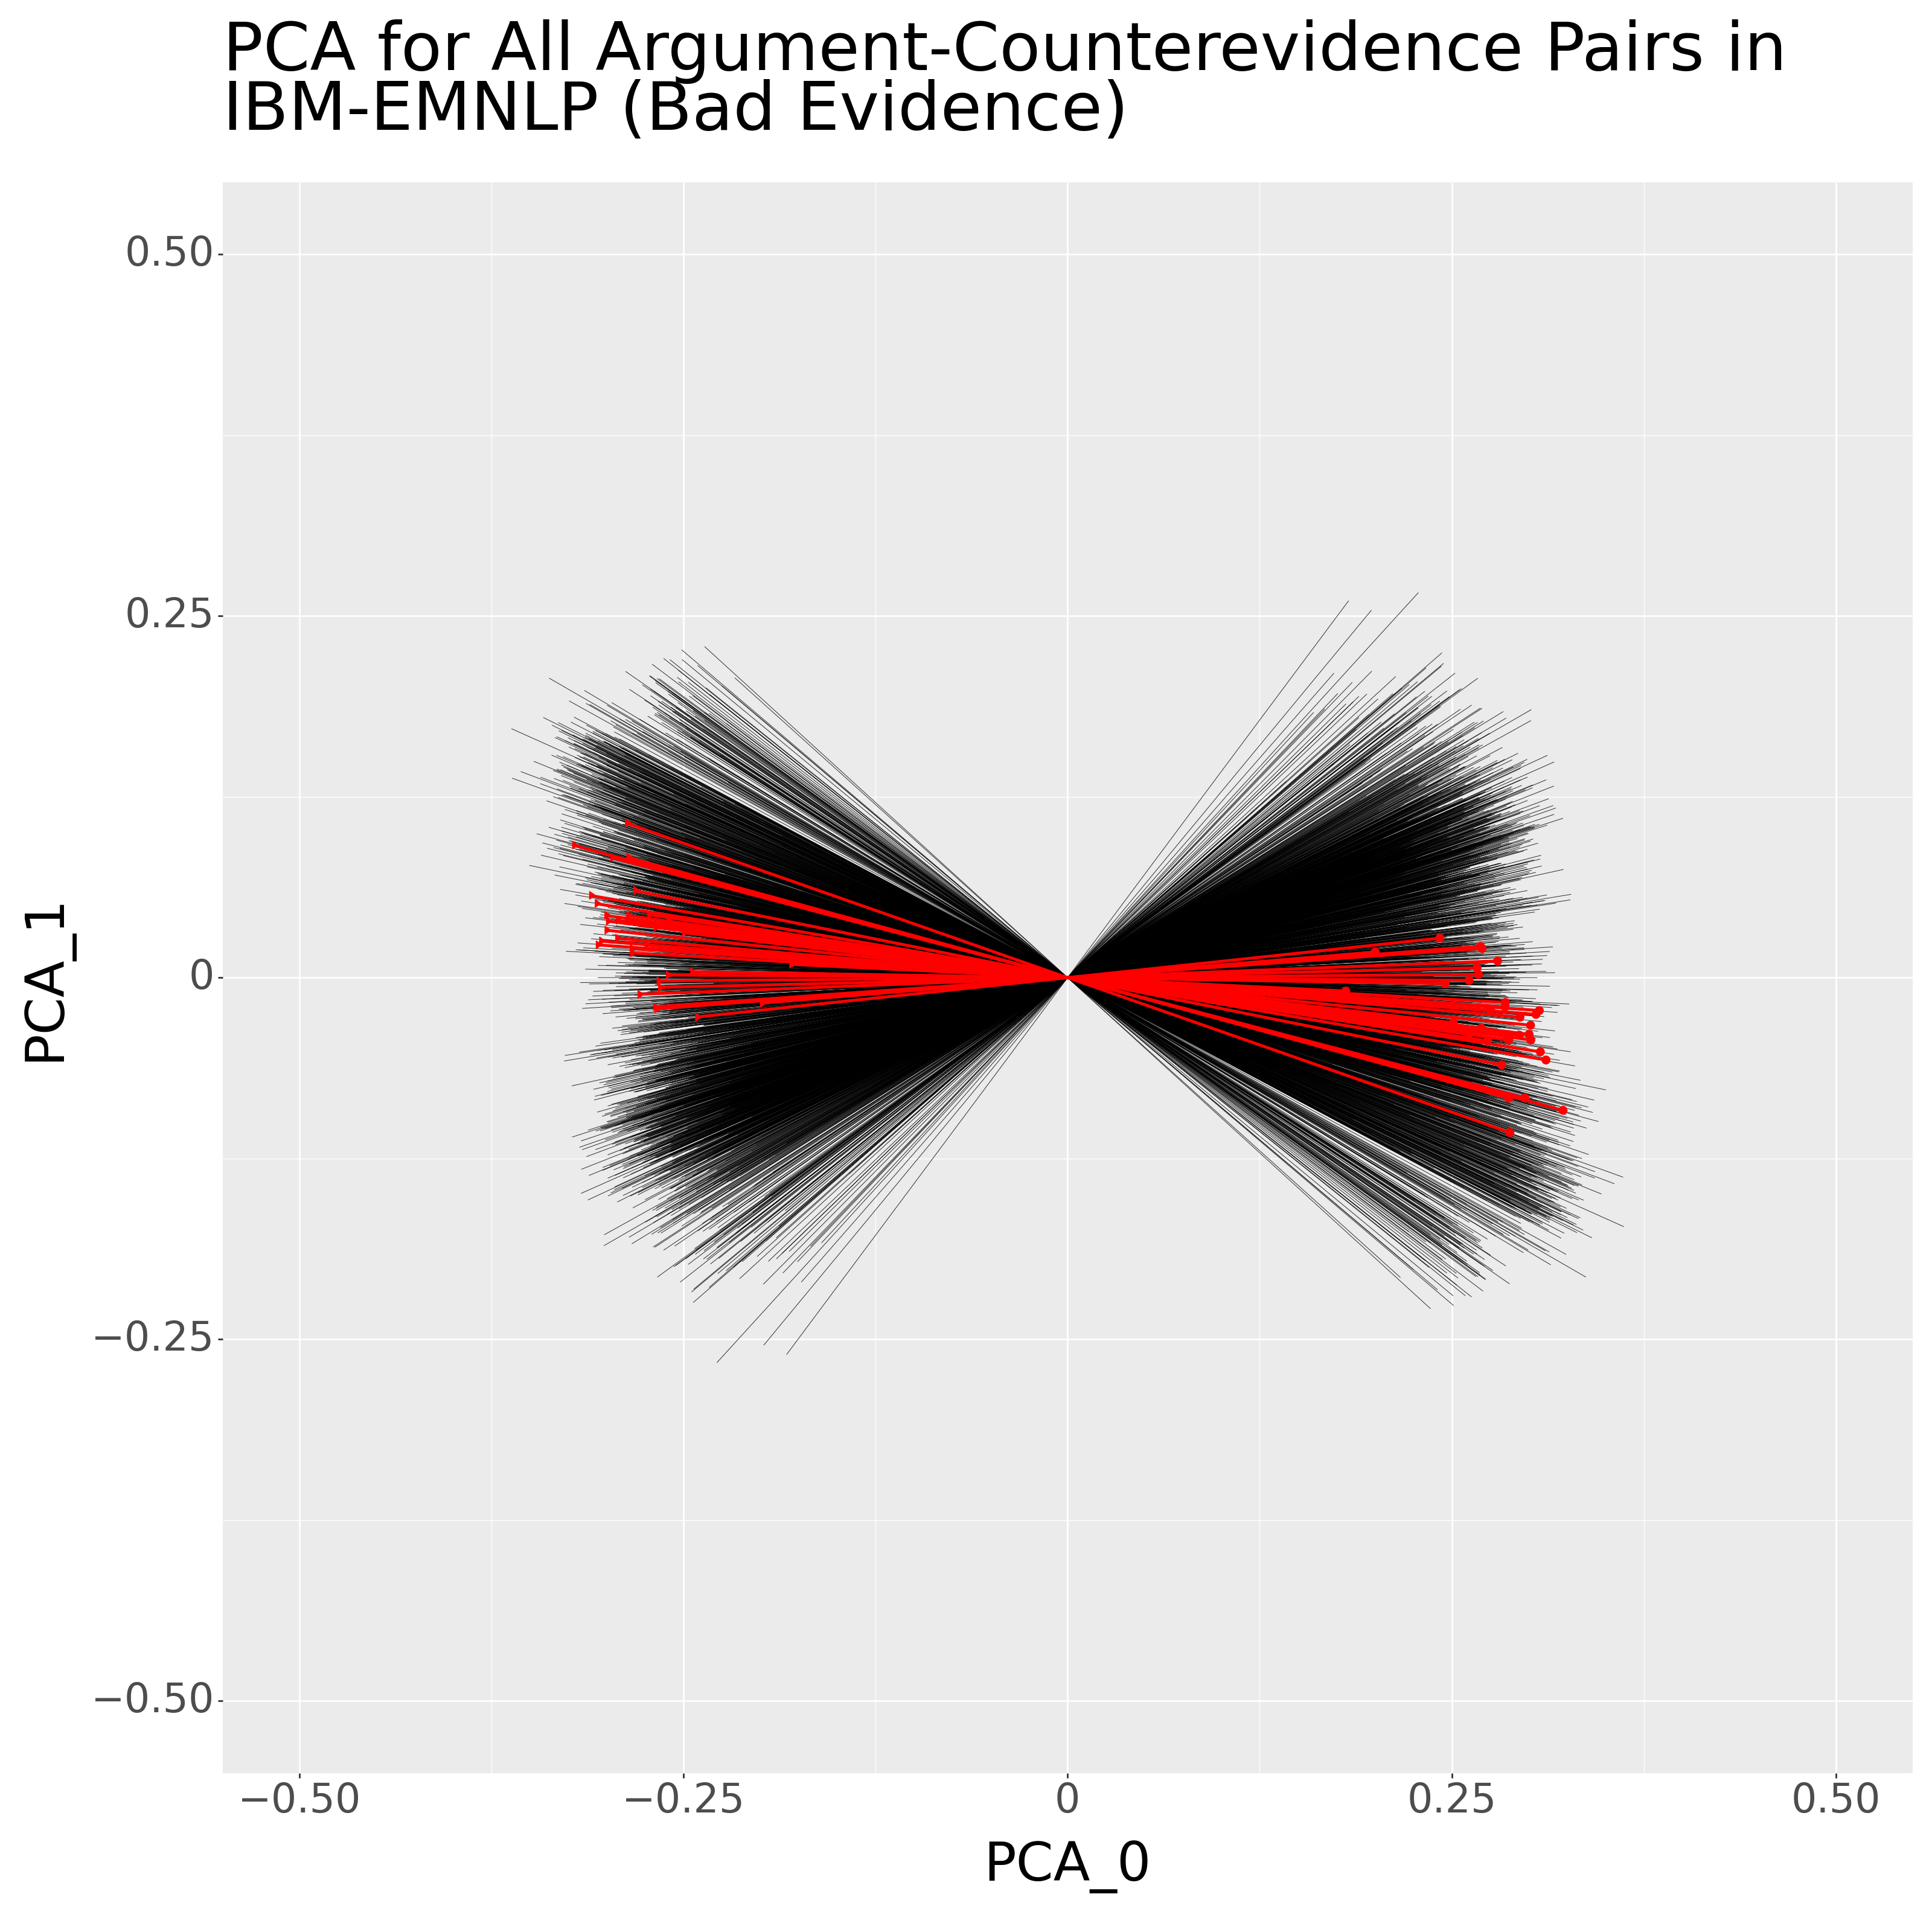

In [ ]:
# Run global level global view pca plot
global_plot(loaded_global_pca_df, "global_pca")

<ipython-input-49-66db2e902f00>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-49-66db2e902f00>:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 16 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/pca-plots-dump/global_shuffled_pca_plot.png


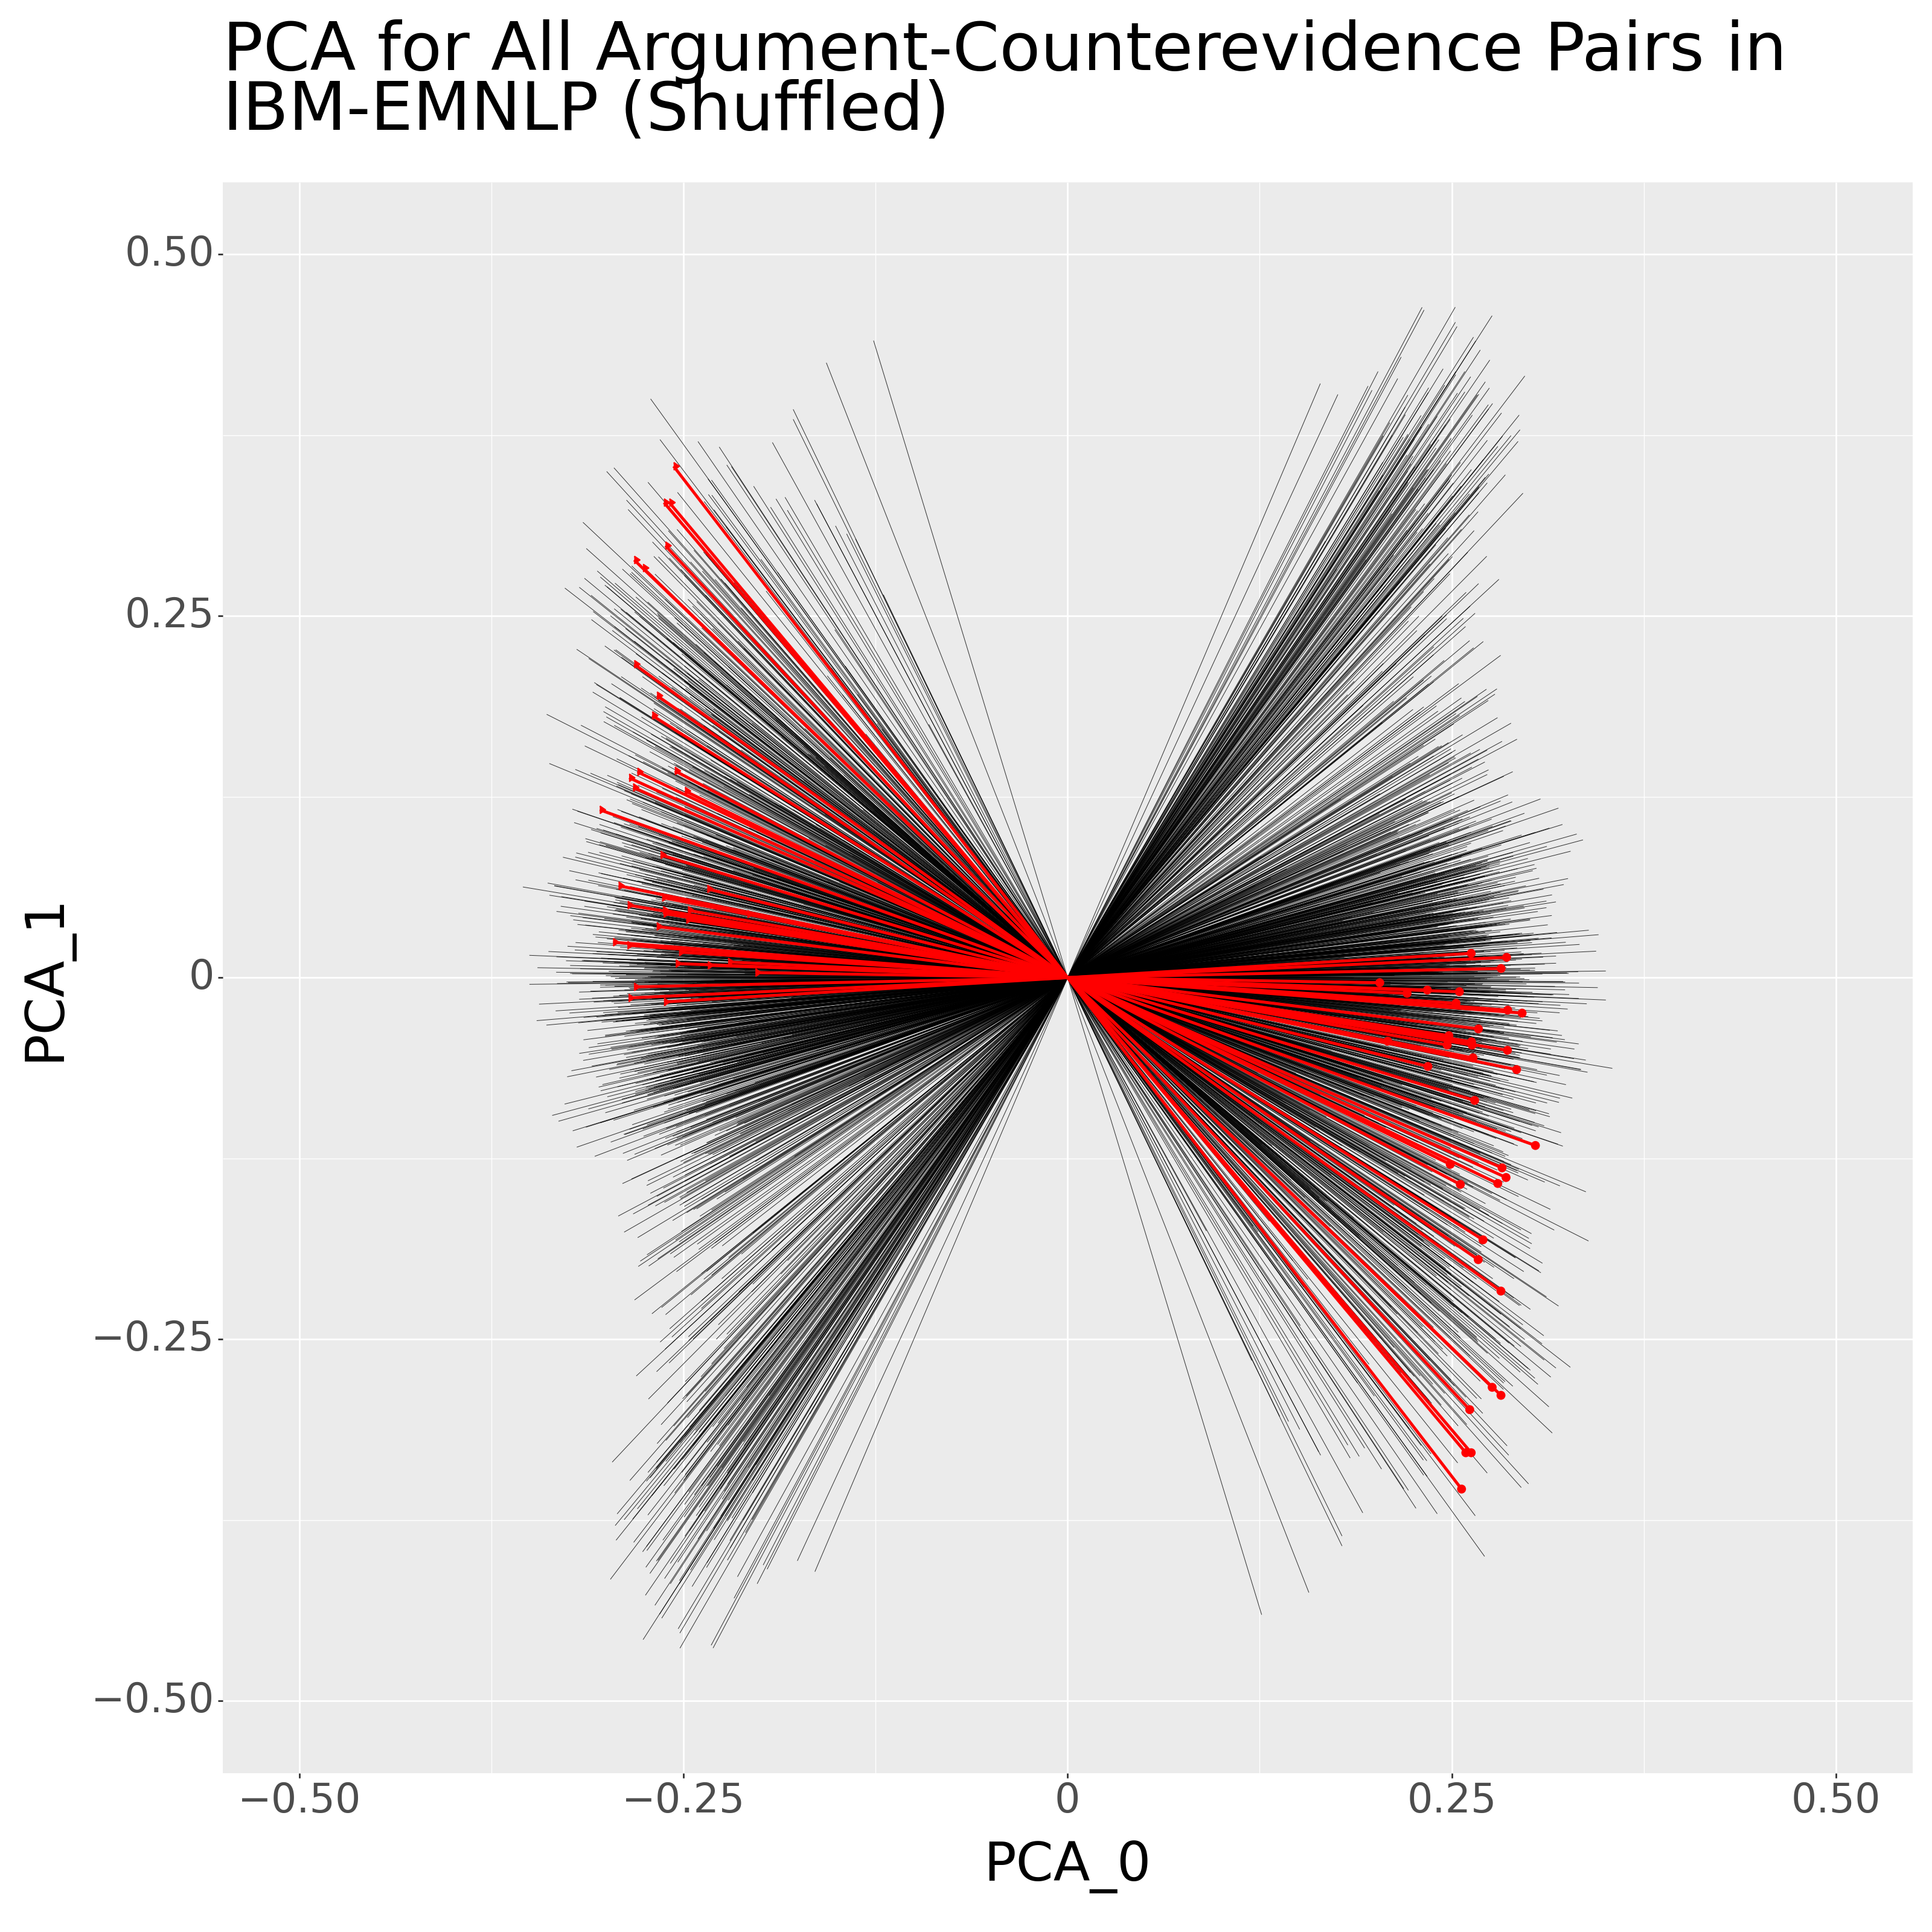

In [ ]:
# Run global level global view pca plot
global_plot(loaded_global_shuffled_pca_df, "global_shuffled_pca")

### [Run] Global PCA Components Plot

In [ ]:
loaded_global_pca_obj = joblib.load("current-data-dump/pca-dump/global_pca_obj.pkl")
global_pca_obj = loaded_global_pca_obj.explained_variance_ratio_
global_pca_obj_df = pd.DataFrame({'pca_explained_ratio': global_pca_obj})
global_pca_obj_df['pca_num'] = global_pca_obj_df.index + 1
global_pca_obj_plot = (
    ggplot(global_pca_obj_df, aes(x='pca_num', y='pca_explained_ratio')) +
    geom_bar(stat="identity") +
    labs(
        title=f'Ratio of Explained Variance for Principal Components 1 to 10'
        ) +
    theme(
        axis_title=element_text(size=32),
        axis_text=element_text(size=24),
        plot_title=element_text(size=40, wrap=True, lineheight=1.5),
        strip_text=element_text(angle=0, hjust=0.5, vjust=1, wrap=True),
        figure_size=(16, 16)
    ) +
    scale_x_continuous(breaks=list(range(int(global_pca_obj_df['pca_num'].min()), int(global_pca_obj_df['pca_num'].max()) + 1)))
)
ggsave(global_pca_obj_plot, "current-data-dump/pca-plots-dump/global_pca_components_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 16 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/pca-plots-dump/bad_global_pca_components_plot.png


In [ ]:
loaded_global_shuffled_pca_obj = joblib.load("current-data-dump/pca-dump/global_shuffled_pca_obj.pkl")
global_shuffled_pca_obj = loaded_global_shuffled_pca_obj.explained_variance_ratio_
global_shuffled_pca_obj_df = pd.DataFrame({'pca_explained_ratio': global_shuffled_pca_obj})
global_shuffled_pca_obj_df['pca_num'] = global_shuffled_pca_obj_df.index + 1
global_shuffled_pca_obj_plot = (
    ggplot(global_shuffled_pca_obj_df, aes(x='pca_num', y='pca_explained_ratio')) +
    geom_bar(stat="identity") +
    labs(
        title=f'Ratio of Explained Variance for Principal Components 1 to 10 (shuffled)'
        ) +
    theme(
        axis_title=element_text(size=32),
        axis_text=element_text(size=24),
        plot_title=element_text(size=40, wrap=True, lineheight=1.5),
        strip_text=element_text(angle=0, hjust=0.5, vjust=1, wrap=True),
        figure_size=(16, 16)
    ) +
    scale_x_continuous(breaks=list(range(int(global_shuffled_pca_obj_df['pca_num'].min()), int(global_shuffled_pca_obj_df['pca_num'].max()) + 1)))
)
ggsave(global_shuffled_pca_obj_plot, "current-data-dump/pca-plots-dump/global_shuffled_pca_components_plot.png")

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 16 x 16 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: current-data-dump/pca-plots-dump/global_shuffled_pca_components_plot.png


### [Run] Export PCA Plots Dump to OSF

In [ ]:
export_pca_plots_dump()

Zip file created at: current-data-dump/pca-plots-dump

File: current-data-dump/pca-plots-dump uploaded at osfstorage


### [Run] Import PCA Plots Dump from OSF

In [ ]:
import_pca_plots_dump()

pca_evidence_plots_dump.zip successfully imported
Files extracted: ['global_shuffled_pca_components_plot.png', 'bad_global_pca_components_plot.png', 'bad_global_pca_plot.png', 'global_pca_components_plot.png', 'global_shuffled_pca_plot.png', '.ipynb_checkpoints', 'global_pca_plot.png']
